importing modules

In [1]:
import os
import torch
import numpy as np
import tqdm as tqdm
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader


Loading the data from the preprocessed data(MRI BRAIN)

In [3]:
# def npy_loader(path):
#     sample = torch.from_numpy(np.load(path))
#     return sample

In [4]:
# Data_dir="Dataset/processed/train/normal"
# nii_files = [f for f in os.listdir(Data_dir) if f.endswith(".npy")]
# for file in tqdm(nii_files, desc="Loading Preprocessed Mri"):
#     data = np.load()
#     dataset = datasets.DatasetFolder(
#     root=os.path.join(Data_dir, file),
#     loader=npy_loader,
#     extensions=['.npy']
# )

In [2]:
class Mridataset(Dataset):
    def __init__(self,dataset_dir):
        self.path=dataset_dir
        self.filenames=[f for f in os.listdir(self.path) if f.endswith(".npy")]
    def __getitem__(self,index):
        tensor_data=torch.from_numpy(np.load(os.path.join(self.path,self.filenames[index])))
        tensor_data=tensor_data.to(torch.float32)
        tensor_data=tensor_data.reshape(1, 128, 128 )
        return tensor_data
    def __len__(self):
        return len(self.filenames)
    



Data loading and visalising

In [3]:
path="../Dataset/processed/train/normal"
dataset=Mridataset(path)


In [4]:
train_ratio = 0.8
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = total_size - train_size
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size]
)

from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)


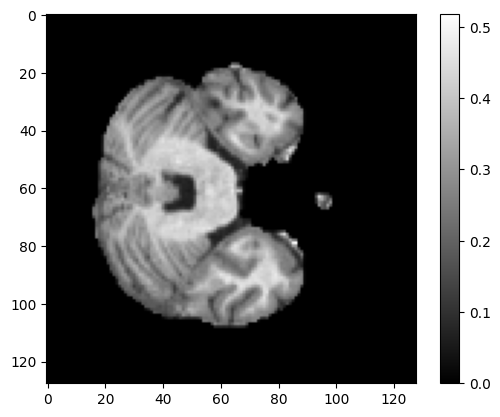

In [7]:
import matplotlib.pyplot as plt

img = dataset[0][0]
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()


Loading dataset for feading the gpu effecient to train the data and so onn

In [5]:
# dataloader=DataLoader(dataset,batch_size=30,shuffle=True)
dataiterator=iter(train_loader)
batch=next(dataiterator)
print(batch.shape)
print(batch.dtype)
print(batch.min().item(), batch.max().item())


torch.Size([32, 1, 128, 128])
torch.float32
0.0 0.9042688608169556


Sanitycheck

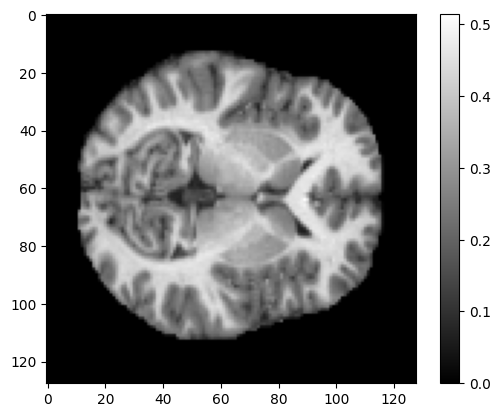

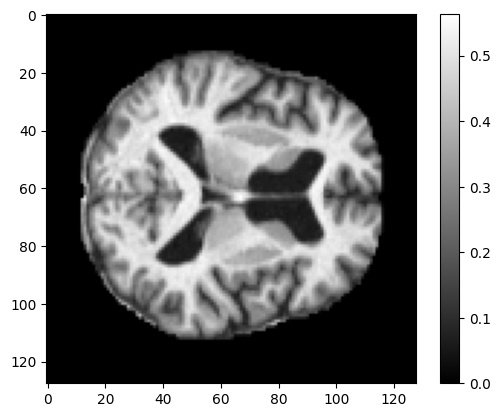

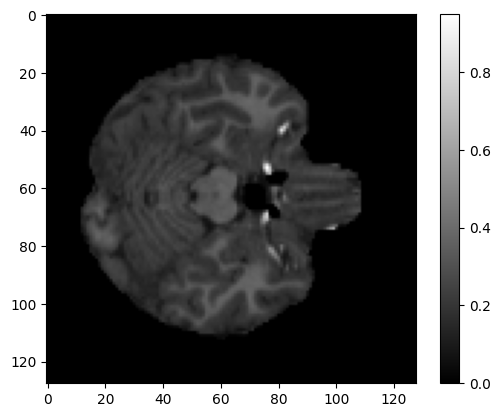

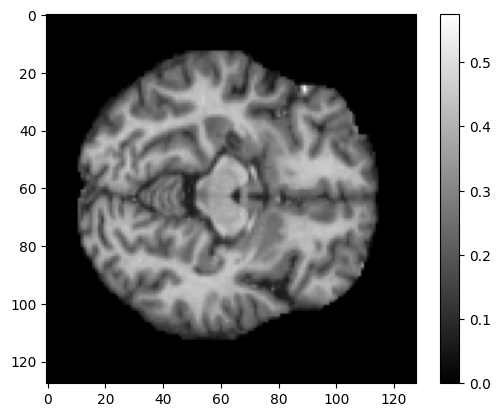

In [37]:
import random
for _ in range(4):
    bn=random.randint(0,29)
    img = batch[bn][0]
    plt.imshow(img, cmap="gray")
    plt.colorbar()
    plt.show()

Make Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [10]:
# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()

#         # -------- Encoder --------
#         self.encoder = nn.Sequential(
#             # Input: (B, 1, 128, 128)
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),

#             # Downsample → (B, 16, 64, 64)
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),

#             # Downsample → (B, 32, 32, 32)
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
#             nn.ReLU()
#         )

#         # -------- Decoder --------
#         self.decoder = nn.Sequential(
#             # Upsample → (B, 64, 64, 64)
#             nn.Upsample(scale_factor=2, mode="nearest"),
#             nn.Conv2d(64, 32, kernel_size=3, padding=1),
#             nn.ReLU(),

#             # Upsample → (B, 32, 128, 128)
#             nn.Upsample(scale_factor=2, mode="nearest"),
#             nn.Conv2d(32, 16, kernel_size=3, padding=1),
#             nn.ReLU(),

#             # Reconstruct → (B, 1, 128, 128)
#             nn.Conv2d(16, 1, kernel_size=3, padding=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            # Input: (B, 1, 128, 128)
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Downsample → (B, 16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Downsample → (B, 32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # -------- Decoder --------
        self.decoder = nn.Sequential(
            # Upsample → (B, 64, 64, 64)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Upsample → (B, 32, 128, 128)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),

            # Reconstruct → (B, 1, 128, 128)
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



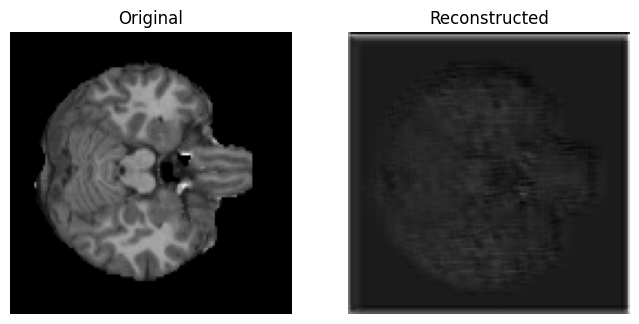

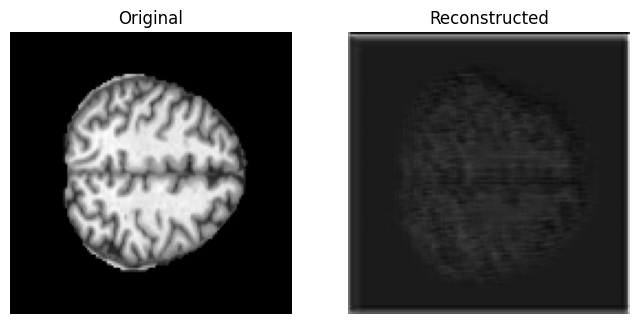

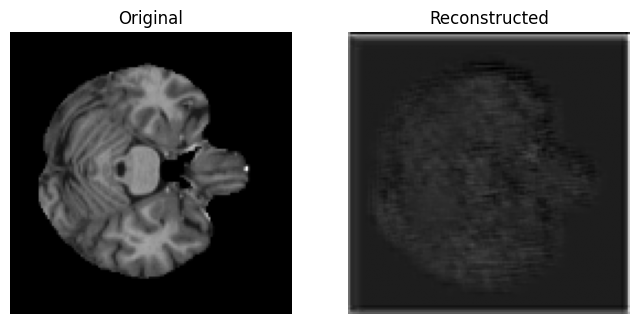

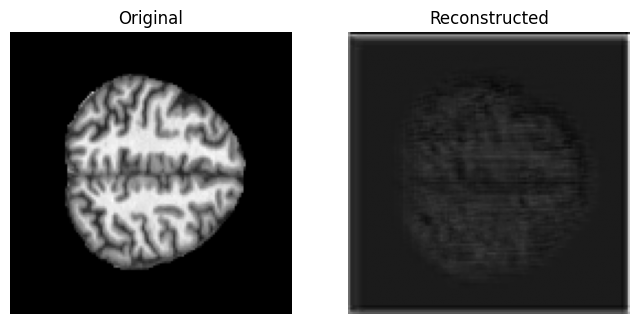

In [52]:
model=Autoencoder()
import random
model.eval()  

with torch.no_grad():  
    recon = model(batch)

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(batch[i][0], cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(recon[i][0], cmap="gray")
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")

    plt.show()



Training face

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

Device being used: cuda


In [12]:
model = Autoencoder().to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [56]:

num_epochs = 20   

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch in train_loader:
        batch = batch.to(device)

        # -------- Forward pass --------
        output = model(batch)
        loss = criterion(output, batch)

        # -------- Backpropagation --------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.6f}")


Epoch [1/20]  Loss: 0.009430
Epoch [2/20]  Loss: 0.000441
Epoch [3/20]  Loss: 0.000318
Epoch [4/20]  Loss: 0.000278
Epoch [5/20]  Loss: 0.000254
Epoch [6/20]  Loss: 0.000236
Epoch [7/20]  Loss: 0.000223
Epoch [8/20]  Loss: 0.000212
Epoch [9/20]  Loss: 0.000203
Epoch [10/20]  Loss: 0.000196
Epoch [11/20]  Loss: 0.000190
Epoch [12/20]  Loss: 0.000185
Epoch [13/20]  Loss: 0.000179
Epoch [14/20]  Loss: 0.000174
Epoch [15/20]  Loss: 0.000169
Epoch [16/20]  Loss: 0.000164
Epoch [17/20]  Loss: 0.000160
Epoch [18/20]  Loss: 0.000156
Epoch [19/20]  Loss: 0.000152
Epoch [20/20]  Loss: 0.000149


In [13]:
PATH="autoencoder_mri2.pth"
torch.save(model.state_dict(), PATH)

Laoding the saved model

In [14]:
Path="autoencoder_mri2.pth"
model=Autoencoder()
model.load_state_dict(torch.load(Path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Checking after training the model

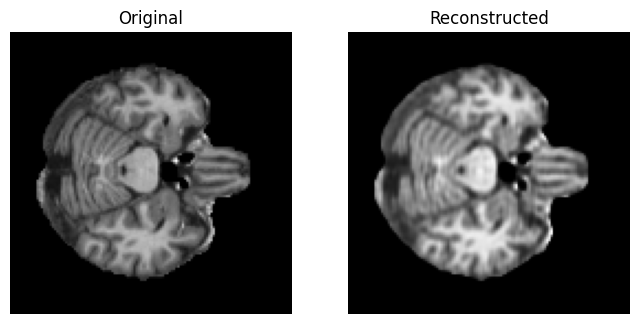

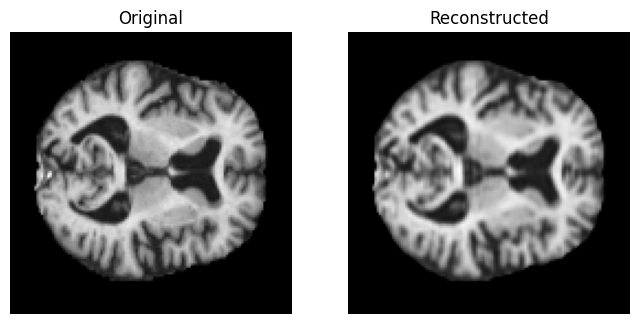

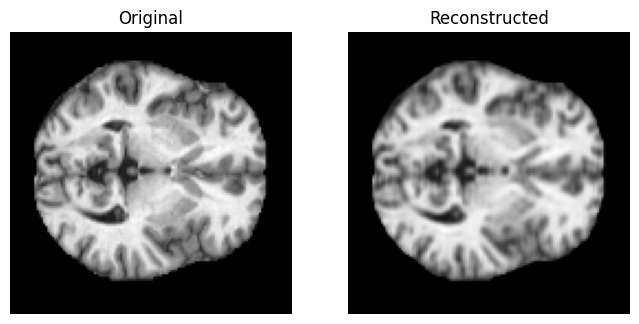

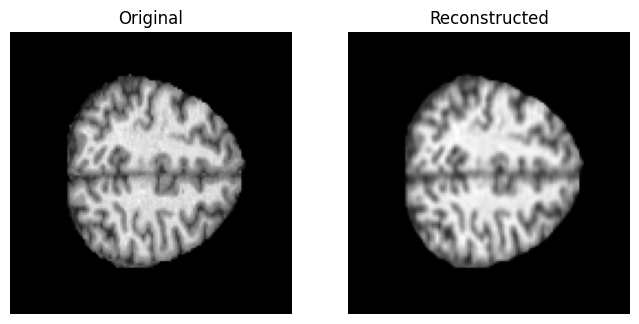

In [59]:
model.eval()

with torch.no_grad():
        recon = model(batch.to(device))

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    original = batch[i][0].cpu().numpy()
    reconstructed = recon[i][0].cpu().numpy()

    ax[0].imshow(original, cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(reconstructed, cmap="gray")
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")

    plt.show()



Evaluating Scores

In [60]:
model.eval()
scores=[]
for batch in train_loader:
    batch = batch.to(device)
    with torch.no_grad():
        recon = model(batch)
    for i in range(batch.size(0)):
        loss = criterion(batch[i][0], recon[i][0])
        scores.append(loss.item())
        

In [61]:
print (scores)

[9.995817526942119e-05, 0.00021619649487547576, 0.00013311182556208223, 0.00018706536502577364, 0.00014024169649928808, 0.0001939498179126531, 8.582752343500033e-05, 0.0002375122276134789, 0.00013470060366671532, 0.00018073766841553152, 8.445252751698717e-05, 8.184072794392705e-05, 9.275000775232911e-05, 0.00012706575216725469, 0.00010487240797374398, 0.0001892026193672791, 8.506924496032298e-05, 0.00010666112211765721, 0.00011082323180744424, 0.00019679413526318967, 6.405617750715464e-05, 6.425009632948786e-05, 0.0001229559857165441, 0.00011489641474327073, 0.00012398228864185512, 0.00014141140854917467, 0.00010964192188112065, 0.00015317031648010015, 6.261051021283492e-05, 0.0001660575799178332, 0.00012981021427549422, 0.00015310646267607808, 0.00014110555639490485, 0.00016994314501062036, 0.00012913276441395283, 0.00012453690578695387, 0.0001270015345653519, 0.00010586217831587419, 0.00010967117123072967, 0.00010239889525109902, 0.00020052776380907744, 0.00010994548938469961, 0.0001

Evaluating the scors for anomally detection  threshold

In [62]:
scoresmean=np.mean(scores)
scoresstd=np.std(scores)
threshold=scoresmean + 3*scoresstd
print("Anomaly Detection Threshold:", threshold)

Anomaly Detection Threshold: 0.00030774008859538074


In [63]:
model.eval()
scoresonval=[]
for batch in val_loader:
    batch = batch.to(device)
    with torch.no_grad():
        recon = model(batch)
    for i in range(batch.size(0)):
        loss = criterion(batch[i][0], recon[i][0])
        scoresonval.append(loss.item())
        

In [65]:
scoresmeanval=np.mean(scoresonval)
scoresstdval=np.std(scoresonval)
thresholdval=scoresmeanval + 3*scoresstdval
print("Anomaly Detection Threshold:", thresholdval)

Anomaly Detection Threshold: 0.00030672586401338177


check weather the modelis working or not

In [15]:
import torch
import random

def corrupt_batch(batch, min_frac=0.15, max_frac=0.3):
    """
    batch: (B, 1, H, W)
    returns corrupted batch
    """
    corrupted = batch.clone()
    B, C, H, W = corrupted.shape

    for i in range(B):
        box_size = random.randint(int(min_frac * H), int(max_frac * H))
        x = random.randint(0, H - box_size)
        y = random.randint(0, W - box_size)

        corrupted[i, :, x:x+box_size, y:y+box_size] = 0.0  # black occlusion

    return corrupted


In [16]:
model.eval()

val_normal_scores = []
val_corrupt_scores = []

with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)

        # ---- Normal reconstruction ----
        recon_normal = model(batch)

        # ---- Corrupted reconstruction ----
        batch_corrupt = corrupt_batch(batch)
        recon_corrupt = model(batch_corrupt)

        for i in range(batch.size(0)):
            loss_normal = criterion(batch[i], recon_normal[i])
            loss_corrupt = criterion(batch_corrupt[i], recon_corrupt[i])

            val_normal_scores.append(loss_normal.item())
            val_corrupt_scores.append(loss_corrupt.item())


In [17]:
import numpy as np

mean_val = np.mean(val_normal_scores)
std_val  = np.std(val_normal_scores)

threshold = mean_val + 3 * std_val

print("Validation Threshold:", threshold)


Validation Threshold: 0.1930633383789277


In [18]:
print("Normal mean:", np.mean(val_normal_scores))
print("Corrupt mean:", np.mean(val_corrupt_scores))


Normal mean: 0.149688295968835
Corrupt mean: 0.15624086854501654


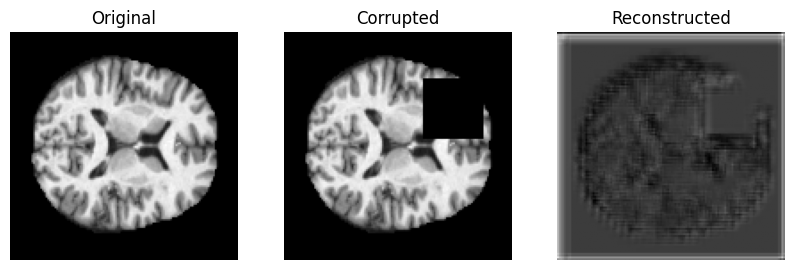

In [19]:
import matplotlib.pyplot as plt

i = 0
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(batch[i][0].cpu(), cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(batch_corrupt[i][0].cpu(), cmap="gray")
plt.title("Corrupted")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(recon_corrupt[i][0].cpu(), cmap="gray")
plt.title("Reconstructed")
plt.axis("off")

plt.show()